## Semester Project

### Naive Bayes Model: Baseline
This file is designed to take the data and determine what a baseline model might produce as far as accuracy
given the data we have.  The data is real world, unstructured, and very terse.

### Preprocessing Section
Preprocessing functions that can be useful for NLP projects.  I have broken out all of the
individual functions so each can be independently tested if we want to.  I have created a
normalize function that does the basic combination of proprocessing steps like lowercase,
whitespace cleaning, etc.  I then created a Preprocessing function that uses normalize and
then removes the stopwords and lemmatizes.


In [2]:
import re
import string
import spacy

import contractions
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ltc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ltc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Lowercase the text function
def text_lowercase(text):
    return text.lower()


# Remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result


# convert numbers into words
def convert_number(text):
    inflect_engine = inflect.engine()

    # split string into list of words
    temp_str = text.split()
    # initialise empty list
    new_string = []

    for word in temp_str:
        # if word is a digit, convert the digit
        # to numbers and append into the new_string list
        if word.isdigit():
            temp = inflect_engine.number_to_words(word)
            new_string.append(temp)

        # append the word as it is
        else:
            new_string.append(word)

    # join the words of new_string to form a string
    temp_str = ' '.join(new_string)
    return temp_str


# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


# remove whitespace from text
def remove_whitespace(text):
    return " ".join(text.split())


# Replace contractions in string of text
def replace_contractions(text):
    return contractions.fix(text)


# Remove URLs from a sample string
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)


# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text


# Check if each character in string is ASCII
# The first 128 unicode code points represent the ASCII characters.
def remove_non_ascii(text):
    return ''.join(char for char in text if ord(char) < 128)


# Lemmatize verbs in list of tokenized words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []

    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)

    return lemmas


# Lemmatizinf using the SpaCy library
def lemmatize_sentence(sentence):
    # Create a Document object
    doc = nlp(sentence)

    # Create list of tokens from given string
    tokens = []
    for token in doc:
        tokens.append(token)

    # put the sentence back together
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])

    return lemmatized_sentence


def normalize(words):
    words = remove_URL(words)
    words = remove_non_ascii(words)
    words = text_lowercase(words)
    words = remove_punctuation(words)
    words = remove_whitespace(words)
    words = replace_contractions(words)
    words = remove_numbers(words)

    return words


# Preprocess text
def preprocess_text(corpus):
    # Normalize all the text
    text = normalize(corpus)

    # Remove the stop words
    text = remove_stopwords(text)

    # Lemmatize and tokenize the text
    text = lemmatize_verbs(text)

    return text


In [4]:
# Remove a row if either column is null
def remove_null_rows_from_injury_dataset(injury_data):
    return injury_data[(injury_data.InjuryDesc.notnull()) & (injury_data.InjuryCauseDesc.notnull())]

### Create Pickle File
I'm doing this because doing the preprocessing over and over again is time-consuming when I am only playing with the
hyperparameters of the model.  So, this way I can pick up after this point if I am not adjusting the structure of the data
I'm working with.

In [ ]:
import pandas as pd
from NaiveBayesTextProcessing import remove_null_rows_from_injury_dataset
from TextPreprocessing import lemmatize_sentence, normalize

In [ ]:
# Reading the data
injuryDataFrame = pd.read_csv("Data/InjuryCauseTopThirteen.csv", sep=',', encoding='latin-1',
                              usecols=lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

# Quick exam of the data
print(injuryDataFrame.head())

# What does the text look like?
print("\n\nSome example injury text:")
print(injuryDataFrame["InjuryDesc"].to_list()[:5])

# Remove the rows that have null
injuryDataFrame = remove_null_rows_from_injury_dataset(injuryDataFrame)

# Normalize the data
injuryDataFrame['processed_desc'] = [normalize(x) for x in injuryDataFrame['InjuryDesc']]

# What does the text look like now?
print("\n\nSome example injury text having been normalized:")
print(injuryDataFrame["processed_desc"].to_list()[:5])

# Lemmatize the sentence.  This takes a while to run on a standard machine
injuryDataFrame['processed_desc'] = [lemmatize_sentence(x) for x in injuryDataFrame['processed_desc']]

# What does the text look like now?
print("\n\nSome example injury text having been lemmatized:")
print(injuryDataFrame["processed_desc"].to_list()[:5])

injuryDataFrame.to_pickle("Data/injury_descriptions_processed.pkl")


### Model Section
This file will contain the construction of a Naive Bayes algorithm using the Sklearn
library.  We will be using worker's compensation injury description data to predict the
cause of injury.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [15]:
# Reading the data from pickle file where it has already been processed
injuryDataFrame = pd.read_pickle("Data/injury_descriptions_processed.pkl")

print(injuryDataFrame.describe())
print("\n")
print("Average length of descriptions:")
print((injuryDataFrame['InjuryDesc'].str.len()).mean())

                                 InjuryCauseDesc InjuryDesc     processed_desc
count                                     101413     101413             101413
unique                                        13     100612             100372
top     Fall to floor, walkway, or other surface    UNKNOWN  repetitive motion
freq                                       15883         76                102


Average length of descriptions:
119.45420212398805


0.5937919066025085
                                                 precision    recall  f1-score   support

Bending, climbing, crawling, reaching, twisting       0.62      0.35      0.44      1434
      Bodily reaction and exertion, unspecified       0.27      0.15      0.19      1783
                        Bodily reaction, n.e.c.       0.32      0.02      0.04      1133
Contact with objects and equipment, unspecified       0.56      0.69      0.62      3351
       Fall to floor, walkway, or other surface       0.62      0.88      0.73      3922
                        Overexertion in lifting       0.56      0.89      0.69      3718
     Overexertion in pulling or pushing objects       0.66      0.35      0.46      1443
                 Repetitive motion, unspecified       0.59      0.79      0.68      1272
     Rubbed or abraded by foreign matter in eye       0.90      0.85      0.87      1069
      Slip, trip, loss of balance--without fall       0.55      0.40      0.46      2203
 

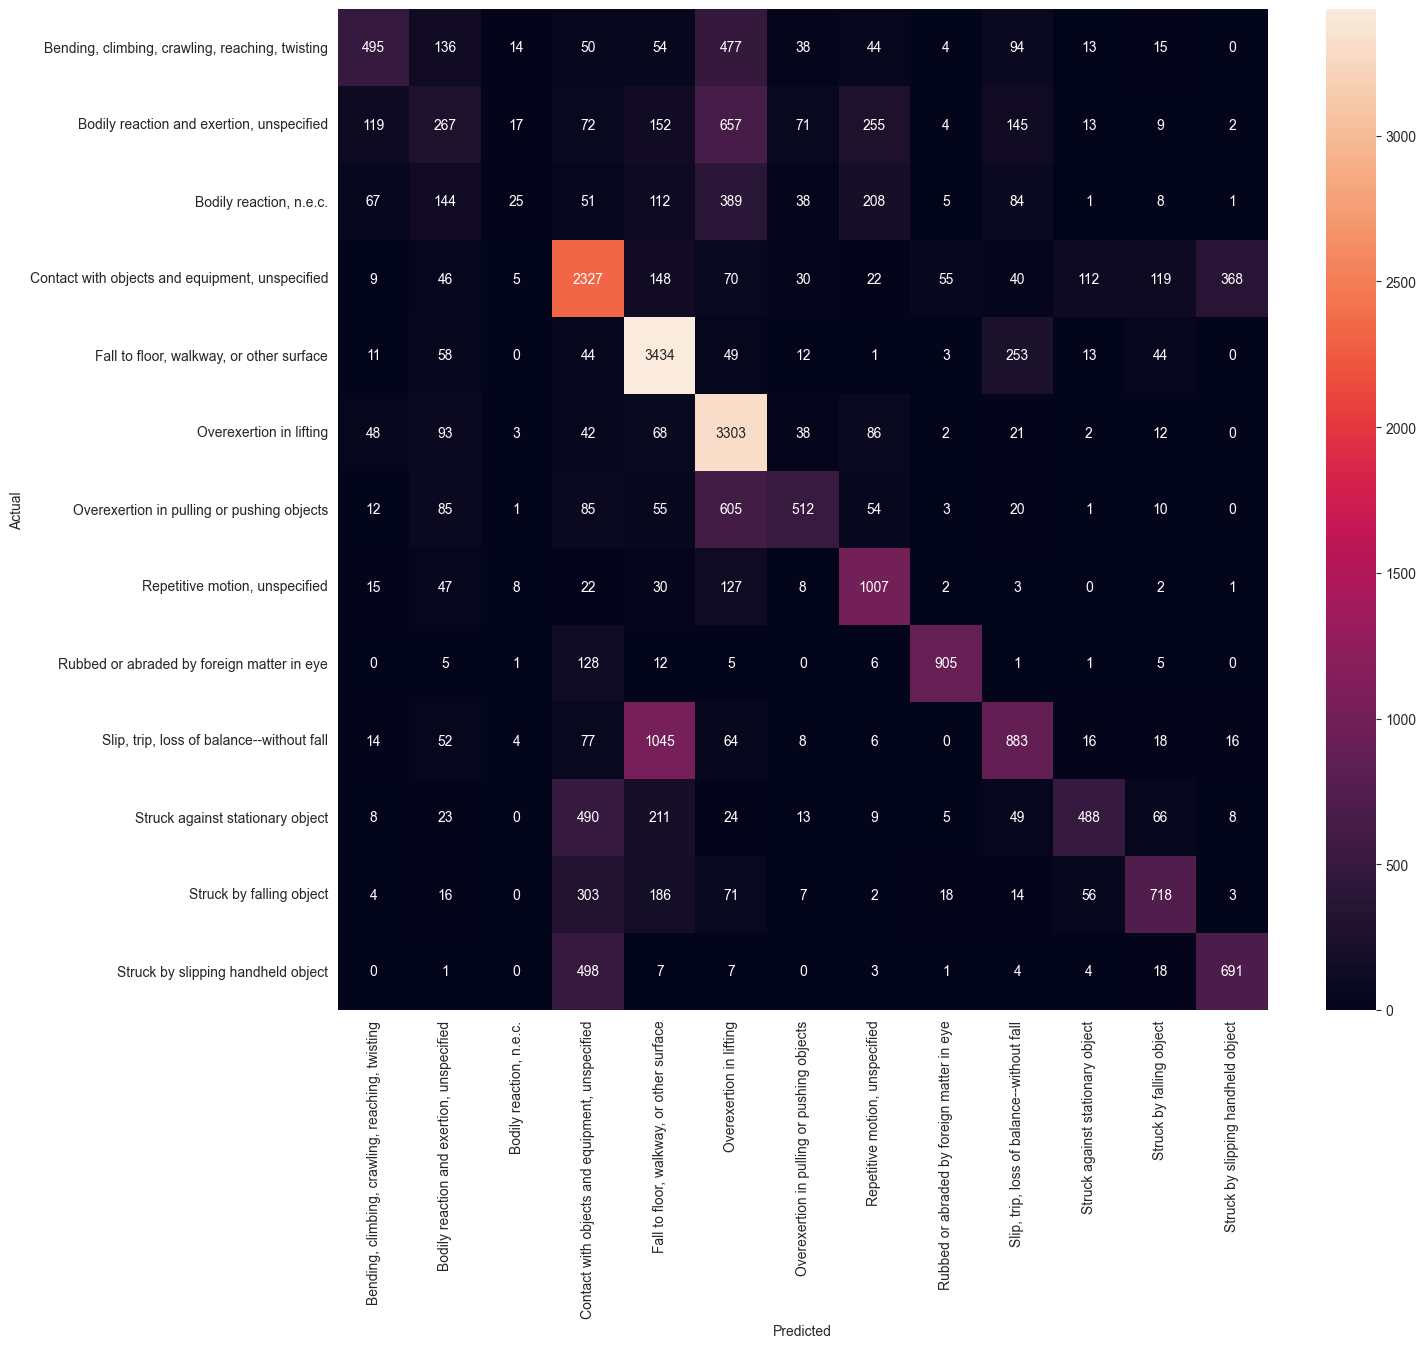

In [2]:
# labels for heat map/confusion matrix
category_id_df = injuryDataFrame[['InjuryCauseDesc']].drop_duplicates().sort_values('InjuryCauseDesc')

# Now that the data has been processed, split it.
X_train, X_test, y_train, y_test = train_test_split(injuryDataFrame['processed_desc'],
                                                    injuryDataFrame['InjuryCauseDesc'],
                                                    random_state=0)

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore")
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Display heatmap confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.InjuryCauseDesc.values, yticklabels=category_id_df.InjuryCauseDesc.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Based on the very low F1 score and confusion matrix, it seems that "Bodily reaction and exertion, unspecified" and "Bodily reaction, n.e.c."
are very low predictors and troublesome categories.  Let's pull those out and re-examine the results.

0.6674820975848419
                                                 precision    recall  f1-score   support

Bending, climbing, crawling, reaching, twisting       0.79      0.38      0.51      1421
Contact with objects and equipment, unspecified       0.57      0.72      0.64      3300
       Fall to floor, walkway, or other surface       0.64      0.88      0.75      3949
                        Overexertion in lifting       0.66      0.91      0.77      3722
     Overexertion in pulling or pushing objects       0.77      0.34      0.47      1466
                 Repetitive motion, unspecified       0.81      0.81      0.81      1292
     Rubbed or abraded by foreign matter in eye       0.90      0.87      0.88      1020
      Slip, trip, loss of balance--without fall       0.64      0.41      0.50      2218
               Struck against stationary object       0.70      0.35      0.46      1336
                       Struck by falling object       0.69      0.48      0.57      1450
 

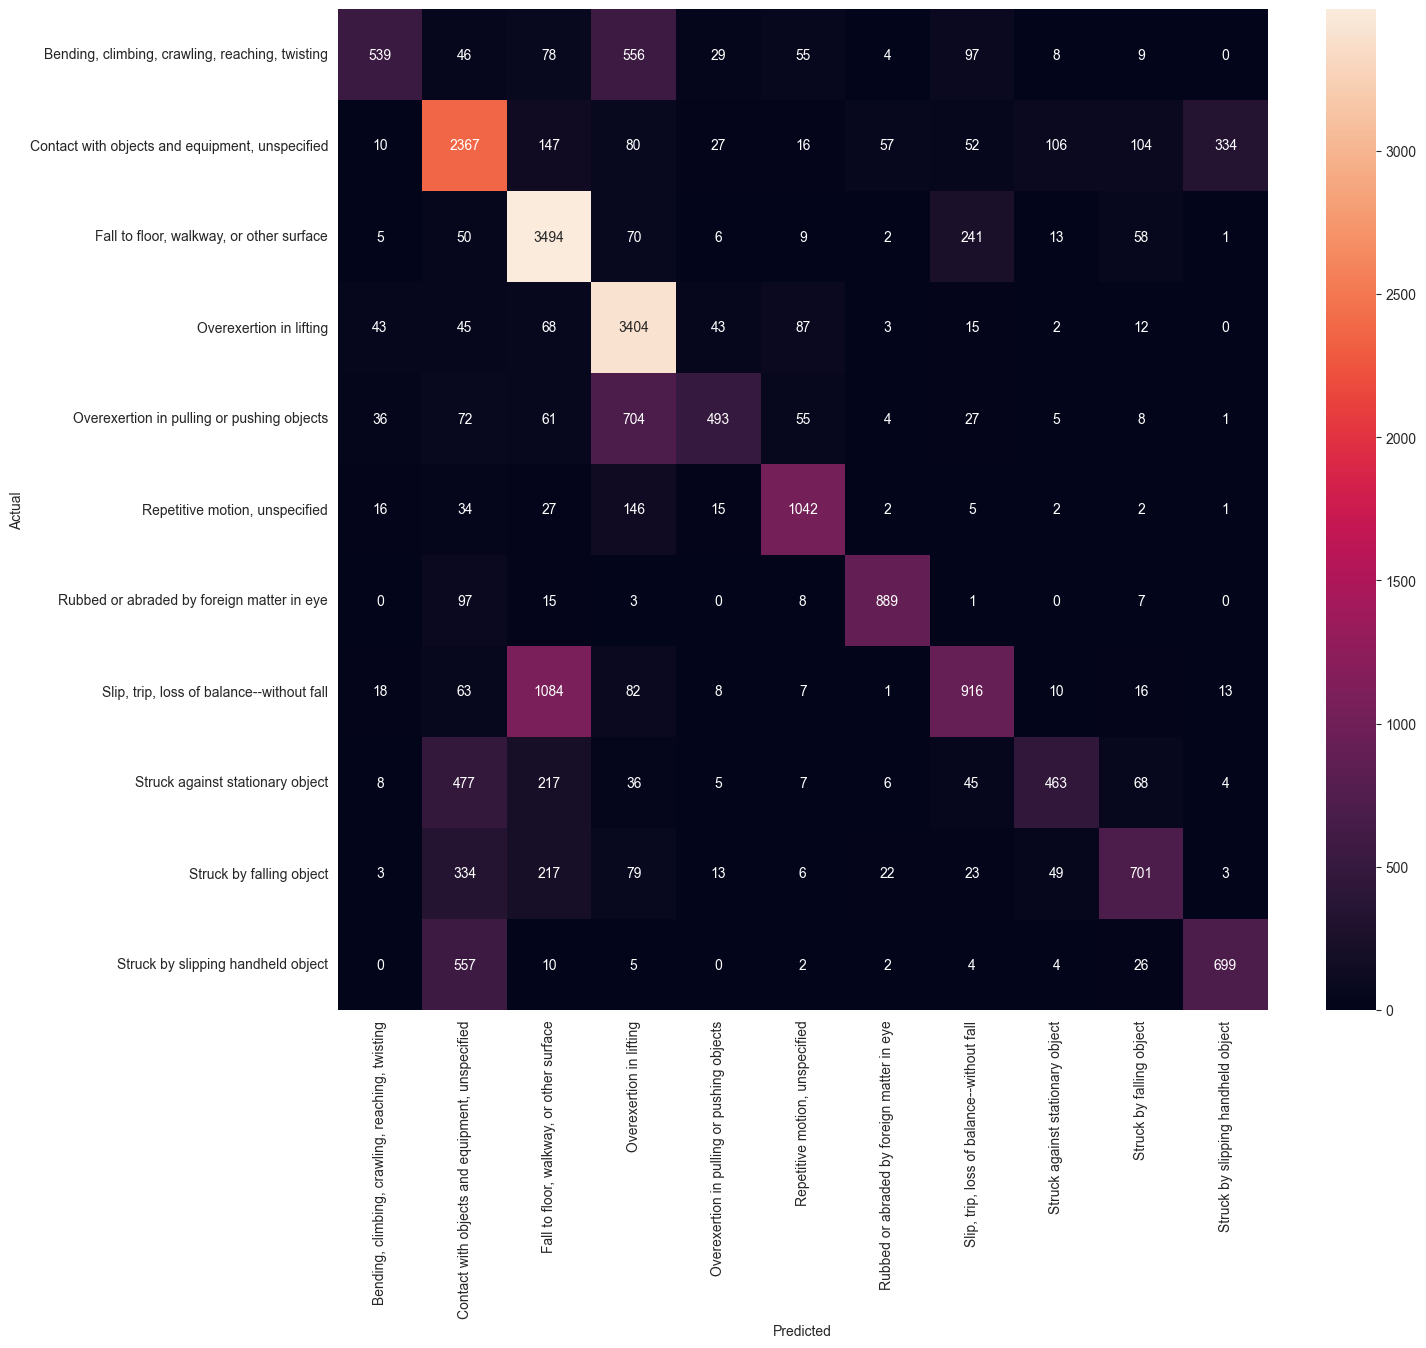

In [3]:
# Removed troublesome category here.  For some reason this one is a very low predictor.
injuryDataFrame = injuryDataFrame[
    ~injuryDataFrame.InjuryCauseDesc.str.contains("Bodily reaction and exertion, unspecified")]
injuryDataFrame = injuryDataFrame[~injuryDataFrame.InjuryCauseDesc.str.contains("Bodily reaction, n.e.c.")]

# labels for heat map/confusion matrix
category_id_df = injuryDataFrame[['InjuryCauseDesc']].drop_duplicates().sort_values('InjuryCauseDesc')

# Now that the data has been processed, split it.
X_train, X_test, y_train, y_test = train_test_split(injuryDataFrame['processed_desc'],
                                                    injuryDataFrame['InjuryCauseDesc'],
                                                    random_state=0)

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore")
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Display heatmap confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.InjuryCauseDesc.values, yticklabels=category_id_df.InjuryCauseDesc.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


It's much better after removing those two low predictor categories.  This is just a straight TF-IDF vectorizing mechanism.  Let's utilize N-Grams to see if we can improve the accuracy.  Start with n-gram(1, 2) and try out a few different ranges.  We will drop the confusion matrix for now and focus on n-grams and effects on accuracy.

In [4]:

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore", ngram_range=(1, 2))
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print("N-gram range (1, 2): ")
print(accuracy_score(y_test, y_pred))

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore", ngram_range=(1, 3))
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print("N-gram range (1, 3): ")
print(accuracy_score(y_test, y_pred))

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore", ngram_range=(1, 4))
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print("N-gram range (1, 4): ")
print(accuracy_score(y_test, y_pred))

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore", ngram_range=(2, 3))
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print("N-gram range (2, 3): ")
print(accuracy_score(y_test, y_pred))

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore", ngram_range=(2, 4))
vectorizer.fit(X_train)

cls = MultinomialNB()

# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)

y_pred = cls.predict(vectorizer.transform(X_test))

# Display metrics
print("N-gram range (2, 4): ")
print(accuracy_score(y_test, y_pred))


N-gram range (1, 2): 
0.6907885958279589
N-gram range (1, 3): 
0.6874527420717875
N-gram range (1, 4): 
0.6868745274207179
N-gram range (2, 3): 
0.5879553440377174
N-gram range (2, 4): 
0.5865320464350843


Accuracy ranges between 58.6% for n-gram(2, 4) to 69% for n-gram(1, 2)

So, using n-gram(1, 2) or (1, 3) does make a difference.  Using both versions of n-grams, what about trying different levels of features?

In [5]:
def prediction(max_features, ngram_range):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=max_features, decode_error="ignore", ngram_range=ngram_range)
    vectorizer.fit(X_train)

    cls = MultinomialNB()

    # transform the list of text to tf-idf before passing it to the model
    cls.fit(vectorizer.transform(X_train), y_train)

    return cls.predict(vectorizer.transform(X_test))

In [6]:
# Display metrics:  N-gram (1, 2)
print("*** For n-gram(1, 2) ***")
print("Max features 2000")
print(accuracy_score(y_test, prediction(2000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 4000")
print(accuracy_score(y_test, prediction(4000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 6000")
print(accuracy_score(y_test, prediction(6000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 8000")
print(accuracy_score(y_test, prediction(8000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 10000")
print(accuracy_score(y_test, prediction(10000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 12000")
print(accuracy_score(y_test, prediction(12000, (1, 2))))
print("\n")

print("*** For n-gram(1, 2) ***")
print("Max features 14000")
print(accuracy_score(y_test, prediction(14000, (1, 2))))
print("\n")

# Display metrics:  N-gram (1, 3)
print("*** For n-gram(1, 3) ***")
print("Max features 2000")
print(accuracy_score(y_test, prediction(2000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 4000")
print(accuracy_score(y_test, prediction(4000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 6000")
print(accuracy_score(y_test, prediction(6000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 8000")
print(accuracy_score(y_test, prediction(8000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 10000")
print(accuracy_score(y_test, prediction(10000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 12000")
print(accuracy_score(y_test, prediction(12000, (1, 3))))
print("\n")

print("*** For n-gram(1, 3) ***")
print("Max features 14000")
print(accuracy_score(y_test, prediction(14000, (1, 3))))
print("\n")

*** For n-gram(1, 2) ***
Max features 2000
0.6983943423920296


*** For n-gram(1, 2) ***
Max features 4000
0.7045767913534671


*** For n-gram(1, 2) ***
Max features 6000
0.7023528888493529


*** For n-gram(1, 2) ***
Max features 8000
0.7013743717475426


*** For n-gram(1, 2) ***
Max features 10000
0.6971489569897256


*** For n-gram(1, 2) ***
Max features 12000
0.6937241471333897


*** For n-gram(1, 2) ***
Max features 14000
0.6896766445759018


*** For n-gram(1, 3) ***
Max features 2000
0.6956811813370102


*** For n-gram(1, 3) ***
Max features 4000
0.7017746741982831


*** For n-gram(1, 3) ***
Max features 6000
0.7003068985455677


*** For n-gram(1, 3) ***
Max features 8000
0.6987056887426055


*** For n-gram(1, 3) ***
Max features 10000
0.6983498643419472


*** For n-gram(1, 3) ***
Max features 12000
0.6963038740381622


*** For n-gram(1, 3) ***
Max features 14000
0.6941244495841302




Based on the data above, it would seem that the hyperparameter set of n-gram(1, 2) with max features set to 4000 give the best overall results at around 70.5% accuracy.  Let's see what the overall statistics and confusion matrix look like with this setup.

0.7045767913534671
                                                 precision    recall  f1-score   support

Bending, climbing, crawling, reaching, twisting       0.76      0.43      0.55      1421
Contact with objects and equipment, unspecified       0.61      0.71      0.65      3300
       Fall to floor, walkway, or other surface       0.71      0.89      0.79      3949
                        Overexertion in lifting       0.70      0.91      0.79      3722
     Overexertion in pulling or pushing objects       0.77      0.45      0.57      1466
                 Repetitive motion, unspecified       0.80      0.83      0.82      1292
     Rubbed or abraded by foreign matter in eye       0.90      0.89      0.89      1020
      Slip, trip, loss of balance--without fall       0.67      0.49      0.57      2218
               Struck against stationary object       0.68      0.43      0.53      1336
                       Struck by falling object       0.76      0.63      0.69      1450
 

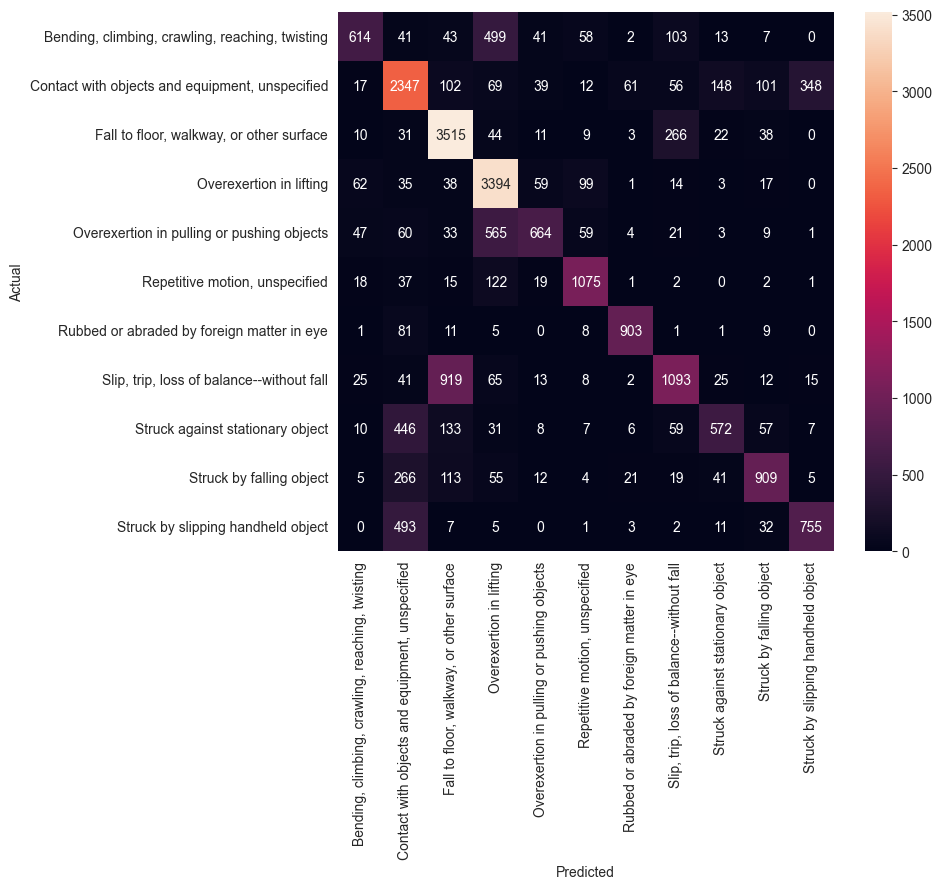

In [9]:
y_pred = prediction(4000, (1, 2))

# Display metrics
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Display heatmap confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.InjuryCauseDesc.values, yticklabels=category_id_df.InjuryCauseDesc.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
